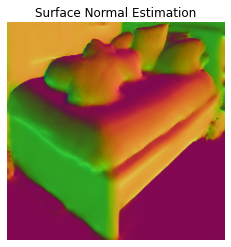

In [1]:
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from surface_snapping.surface_snapping_e2e import snapping
from surface_snapping.helpers import normal_to_RGB

device='cuda'
# Load the input image and the estimated surface normal
# The estimated surface normal is the result by [1]
# [1] Robust Learning Through Cross-Task Consistency, Zamir et al., CVPR 2020.
image = np.array(Image.open('../data/image.jpg'))
normals = torch.Tensor(np.load('../data/normal_map.npy')).to(device)

# Visualize normal
plt.imshow(normal_to_RGB(normals)[0].permute(1,2,0).cpu().numpy());plt.savefig('surface_normal.png')
plt.axis("off");
plt.title('Surface Normal Estimation')

# Load the mesh 
obj_data = load_obj('../data/before_snapping.obj')
mesh_before_snapping = Meshes([obj_data[0]], [obj_data[1].verts_idx]).to(device)

# Perform surface snapping
meshes_compare = [mesh_before_snapping]
for alpha in [0.5,1.0,4.0]:
    meshes_compare.append(snapping(mesh_before_snapping, normals, alpha=alpha))              

In [2]:
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardFlatShader,
    TexturesVertex,
)
# Setup renderer pipeline
R, T = look_at_view_transform(2.5, 180, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
lights = PointLights(device=device, location=[[-5, -5, -5]])
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

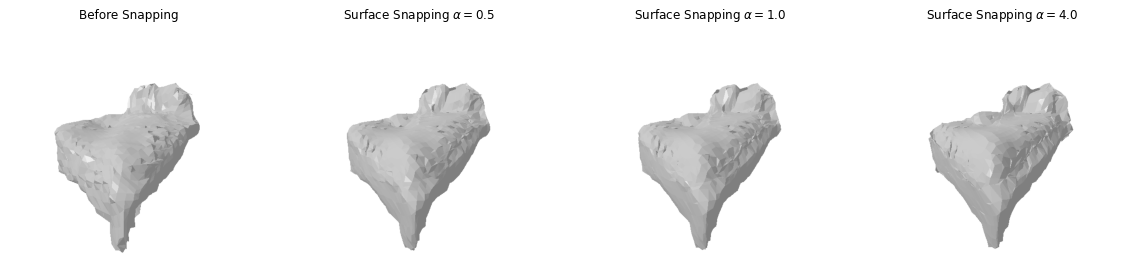

In [3]:
titles = ['Before Snapping',r'Surface Snapping $\alpha=0.5$',
          r'Surface Snapping $\alpha=1.0$',r'Surface Snapping $\alpha=4.0$']
plt.figure(figsize=(20, 10))
for k, title, mesh in zip([1,2,3,4], titles, meshes_compare):
    verts, faces = mesh.verts_list()[0],  mesh.faces_list()[0]
    verts_rgb = torch.ones_like(verts)[None]
    textures = TexturesVertex(verts_features=verts_rgb.to(device))
    mesh_tex = Meshes(verts=[verts], faces=[faces], textures=textures)
    images = renderer(mesh_tex)[0]
    plt.subplot(1,4,k)
    plt.imshow(np.fliplr(np.flipud(images[:,:,:3].cpu().numpy())))
    plt.axis("off");
    plt.title(title)
plt.show()